In [1]:
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import time
import os
from IPython import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_x = loadmat('/content/drive/MyDrive/AML - john & samory/train_32x32.mat')['X']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_x.shape

(32, 32, 3, 73257)

In [4]:
#We need to get the number of images as the first dimension
train_x=train_x.transpose((3,0,1,2))
train_x.shape

(73257, 32, 32, 3)

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100
num_examples_to_generate = 16

In [6]:
# from github - removed if else statement since we have all 32X32 images (made another function later for else part)
def plot_images(img, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        ax.imshow(img[i])


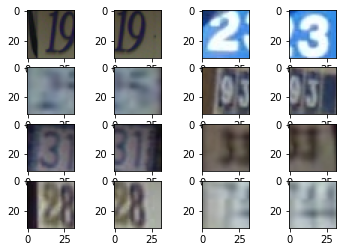

In [7]:
plot_images(train_x, 4, 4)

To speed up our experiments we will convert our images from RGB to Grayscale, which grately reduces the amount of data we will have to process.

Y = 0.2990R + 0.5870G + 0.1140B

Here is a simple function that helps us print the size of a numpy array in a human readable format.

In [8]:
# # # from github
# def rgb2gray(images):
#     return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [9]:
# train_y = rgb2gray(train_x).astype(np.float32)
# test_x = rgb2gray(test_x).astype(np.float32)

In [10]:
#for greyscale- use below code
train_x = tf.image.rgb_to_grayscale(tf.convert_to_tensor(train_x)).numpy().astype(np.float32)

In [11]:
def plot_images(img, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        ax.imshow(img[i,:,:,0])

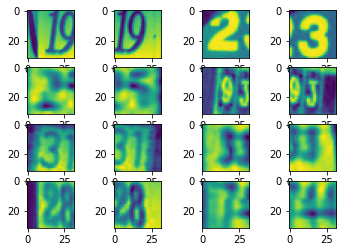

In [12]:
plot_images(train_x, 4, 4)

In [13]:
train_x = (train_x - 127.5) / 127.5 
#test_x = (test_x - 127.5) / 127.5

In [14]:
train_x = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#test_x = tf.data.Dataset.from_tensor_slices(test_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [15]:
def make_generator_model_0():
  """
  Using DNN to generate images
  Input: random vector, shape = (100,)
  Output: image matrix, shape = (None,32,32,1), range = [-1, 1]
  """
  model = tf.keras.Sequential()
  model.add(layers.Dense(256, input_shape=(100,)))
  model.add(layers.Activation('relu'))

  model.add(layers.Dense(1024))
  model.add(layers.Activation('tanh'))

  model.add(layers.Reshape((32, 32, 1)))
  assert model.output_shape == (None, 32, 32, 1)

  return model

In [16]:
def make_discriminator_model_0():
  """
  Input: image matrix, shape = (32,32,1)
  Output: softmax indicating True/False
  """
  model = tf.keras.Sequential()

  model.add(layers.Flatten())

  model.add(layers.Dense(256, activation='relu'))

  model.add(layers.Dense(1, activation = 'sigmoid'))

  return model

In [17]:
generator_0,discriminator_0 = make_generator_model_0(),make_discriminator_model_0()


In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
# from tutorial
def generator_loss(fake_output):
    
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
# from tutorial
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
# from tutorial
@tf.function
def train_step(images, generator, discriminator):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

In [24]:
25%5

0

In [28]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()
  if (epoch==1) or (epoch%50==0):
    plt.savefig('/content/drive/MyDrive/'+model_+'_image_at_epoch_{:04d}.png'.format(epoch))
  

In [29]:
# from tutorial (made some changes)
def train(dataset, epochs, generator, discriminator):

  for epoch in range(epochs):
    start = time.time()

    # train
    loss_train = []
    for image_batch in dataset:
      loss_train.append(train_step(image_batch, generator, discriminator))

    train_loss.loc[len(train_loss)] = np.mean(loss_train, axis=0)

    # tensorboard
    with gen_summary_writer.as_default():
        tf.summary.scalar('generaotr_loss', train_loss.gen_loss.values[-1], step=epoch)
    with disc_summary_writer.as_default():
        tf.summary.scalar('discrinimator_loss', train_loss.disc_loss.values[-1], step=epoch)

    # Produce images for the GIF as we go
    
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    print('Time for epoch {} is {} sec, generation loss: {}, discrimination loss: {}'.format(epoch + 1, time.time()-start, train_loss.gen_loss.values[-1], train_loss.disc_loss.values[-1]))

  # Generate after the final epoch
  
  generate_and_save_images(generator,
                           epochs,
                           seed)
  
  return 
  



In [30]:
# from github - added function
def summary_writer(dir):
    return(tf.summary.create_file_writer(dir))
gen_log_dir = 'logs/gradient_tape/GAN_gen'
disc_log_dir = 'logs/gradient_tape/GAN_disc'
gen_summary_writer = summary_writer(gen_log_dir)
disc_summary_writer = summary_writer(disc_log_dir)

In [31]:
%load_ext tensorboard

In [32]:
train_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
test_loss = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

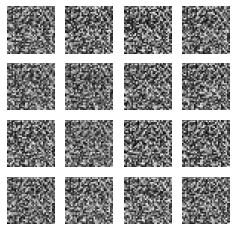

Time for epoch 1 is 2.5334270000457764 sec, generation loss: 0.7756373286247253, discrimination loss: 0.9333277940750122


<Figure size 432x288 with 0 Axes>

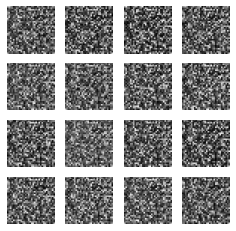

Time for epoch 2 is 1.4353718757629395 sec, generation loss: 0.3524867594242096, discrimination loss: 1.9924514293670654


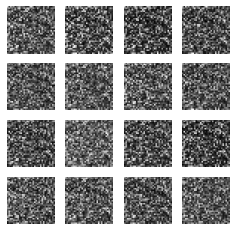

Time for epoch 3 is 1.5108428001403809 sec, generation loss: 0.31266117095947266, discrimination loss: 2.1377484798431396


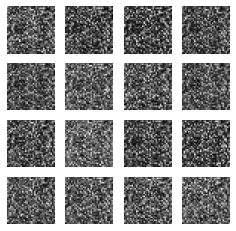

Time for epoch 4 is 1.4224777221679688 sec, generation loss: 0.25755995512008667, discrimination loss: 2.319647789001465


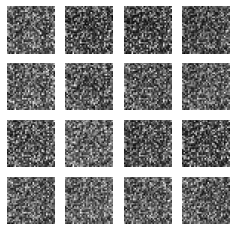

Time for epoch 5 is 1.585920810699463 sec, generation loss: 0.22120621800422668, discrimination loss: 2.39785099029541


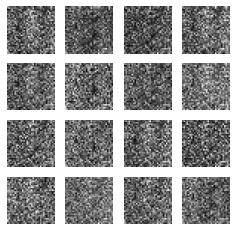

Time for epoch 6 is 1.4247050285339355 sec, generation loss: 0.20694994926452637, discrimination loss: 2.407916307449341


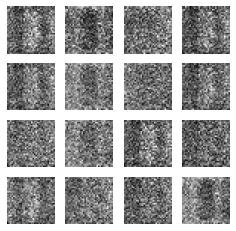

Time for epoch 7 is 1.4644765853881836 sec, generation loss: 0.282789945602417, discrimination loss: 2.033170223236084


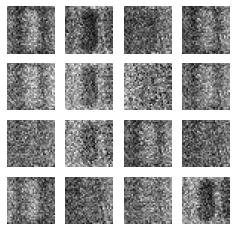

Time for epoch 8 is 1.5588033199310303 sec, generation loss: 0.38082072138786316, discrimination loss: 1.6537442207336426


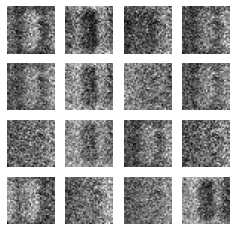

Time for epoch 9 is 1.4281492233276367 sec, generation loss: 0.4137279987335205, discrimination loss: 1.588692307472229


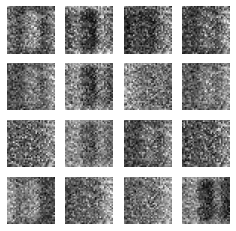

Time for epoch 10 is 1.5248427391052246 sec, generation loss: 0.3913959860801697, discrimination loss: 1.6867488622665405


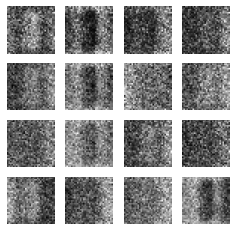

Time for epoch 11 is 1.4081957340240479 sec, generation loss: 0.3249823749065399, discrimination loss: 1.9288581609725952


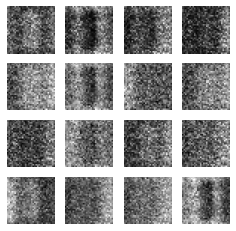

Time for epoch 12 is 1.470313549041748 sec, generation loss: 0.33713340759277344, discrimination loss: 1.9938877820968628


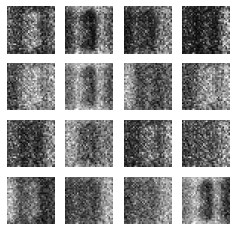

Time for epoch 13 is 1.5416345596313477 sec, generation loss: 0.34934380650520325, discrimination loss: 2.0083961486816406


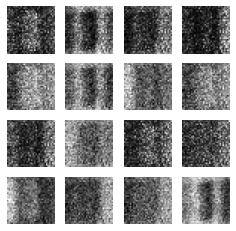

Time for epoch 14 is 1.4158318042755127 sec, generation loss: 0.3648488223552704, discrimination loss: 1.9852772951126099


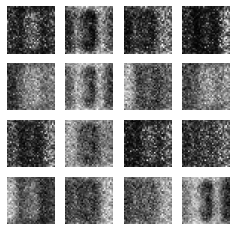

Time for epoch 15 is 1.5384736061096191 sec, generation loss: 0.3443829417228699, discrimination loss: 2.038175582885742


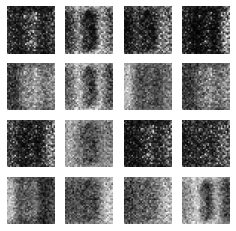

Time for epoch 16 is 1.4856035709381104 sec, generation loss: 0.314286470413208, discrimination loss: 2.139260768890381


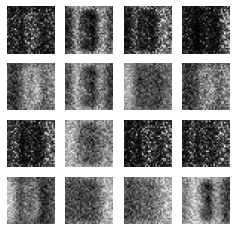

Time for epoch 17 is 1.4651427268981934 sec, generation loss: 0.29060032963752747, discrimination loss: 2.2245447635650635


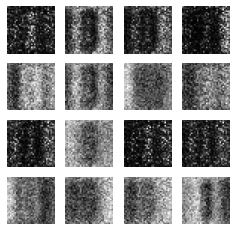

Time for epoch 18 is 1.5541739463806152 sec, generation loss: 0.3064311742782593, discrimination loss: 2.204380512237549


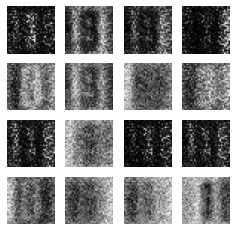

Time for epoch 19 is 1.4091358184814453 sec, generation loss: 0.2988117039203644, discrimination loss: 2.2339131832122803


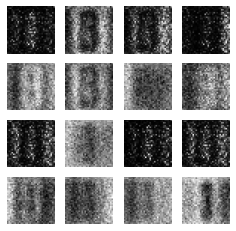

Time for epoch 20 is 1.568000078201294 sec, generation loss: 0.2818503975868225, discrimination loss: 2.282167911529541


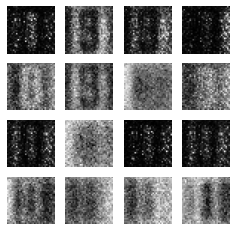

Time for epoch 21 is 1.5040197372436523 sec, generation loss: 0.29221975803375244, discrimination loss: 2.197611093521118


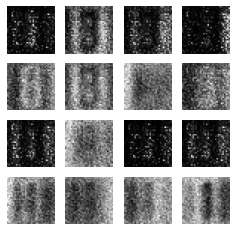

Time for epoch 22 is 1.4472370147705078 sec, generation loss: 0.2789936065673828, discrimination loss: 2.2748160362243652


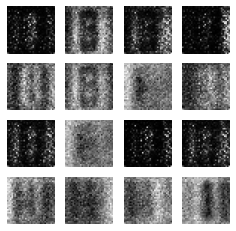

Time for epoch 23 is 1.522695779800415 sec, generation loss: 0.27429473400115967, discrimination loss: 2.33362078666687


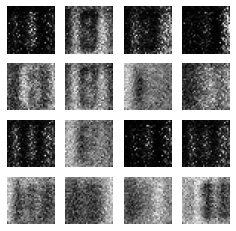

Time for epoch 24 is 1.3760662078857422 sec, generation loss: 0.29217588901519775, discrimination loss: 2.288815975189209


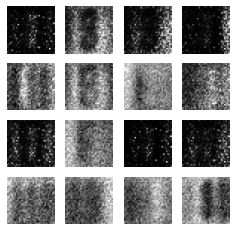

Time for epoch 25 is 1.5211641788482666 sec, generation loss: 0.32187873125076294, discrimination loss: 2.2373220920562744


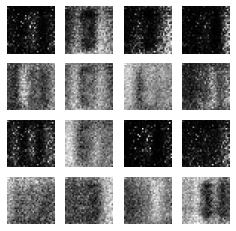

Time for epoch 26 is 1.408928394317627 sec, generation loss: 0.30775320529937744, discrimination loss: 2.304962635040283


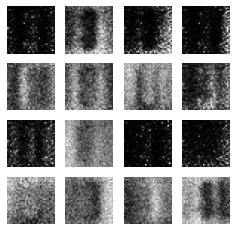

Time for epoch 27 is 1.437269926071167 sec, generation loss: 0.3668019771575928, discrimination loss: 2.151761770248413


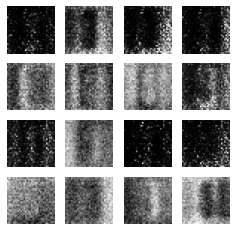

Time for epoch 28 is 1.5183348655700684 sec, generation loss: 0.3866983950138092, discrimination loss: 2.106431722640991


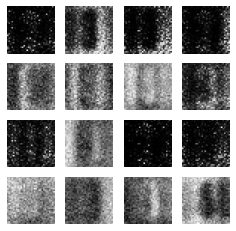

Time for epoch 29 is 1.3958585262298584 sec, generation loss: 0.3745531737804413, discrimination loss: 2.12427020072937


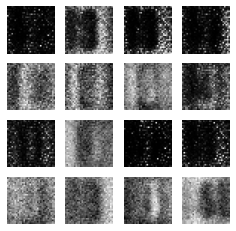

Time for epoch 30 is 1.5528767108917236 sec, generation loss: 0.3887817859649658, discrimination loss: 2.103398084640503


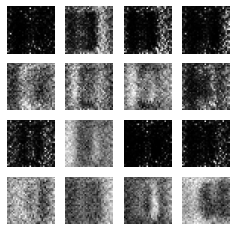

Time for epoch 31 is 1.4832072257995605 sec, generation loss: 0.3787413239479065, discrimination loss: 2.143080234527588


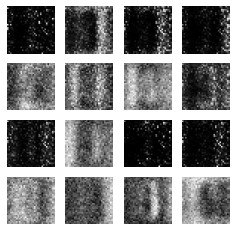

Time for epoch 32 is 1.448197364807129 sec, generation loss: 0.36395829916000366, discrimination loss: 2.172086000442505


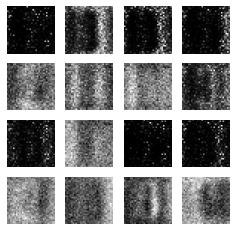

Time for epoch 33 is 1.5367612838745117 sec, generation loss: 0.39229199290275574, discrimination loss: 2.091533660888672


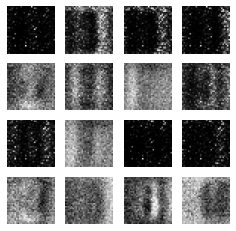

Time for epoch 34 is 1.3929903507232666 sec, generation loss: 0.3636261224746704, discrimination loss: 2.1652801036834717


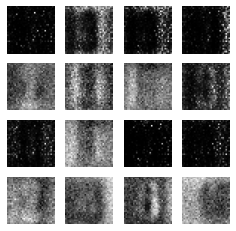

Time for epoch 35 is 1.5173852443695068 sec, generation loss: 0.3421053886413574, discrimination loss: 2.207427501678467


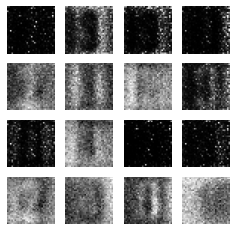

Time for epoch 36 is 1.4876017570495605 sec, generation loss: 0.39551690220832825, discrimination loss: 2.0350630283355713


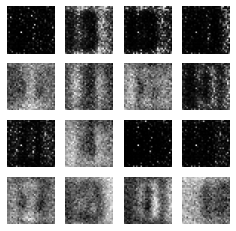

Time for epoch 37 is 1.4661352634429932 sec, generation loss: 0.4186756908893585, discrimination loss: 2.013909101486206


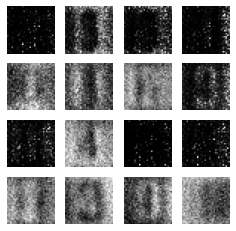

Time for epoch 38 is 1.5678825378417969 sec, generation loss: 0.35793572664260864, discrimination loss: 2.1671128273010254


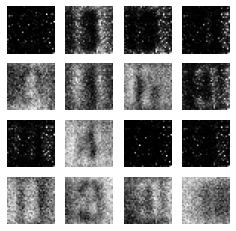

Time for epoch 39 is 1.4719130992889404 sec, generation loss: 0.4152980148792267, discrimination loss: 2.089505195617676


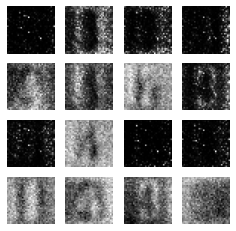

Time for epoch 40 is 1.5775508880615234 sec, generation loss: 0.44787687063217163, discrimination loss: 2.0018723011016846


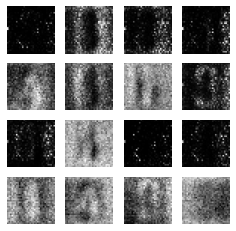

Time for epoch 41 is 1.4164917469024658 sec, generation loss: 0.41082072257995605, discrimination loss: 2.043146848678589


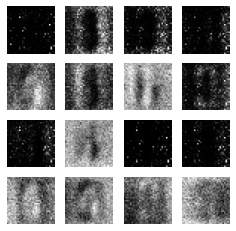

Time for epoch 42 is 1.409937858581543 sec, generation loss: 0.3774838447570801, discrimination loss: 2.1257805824279785


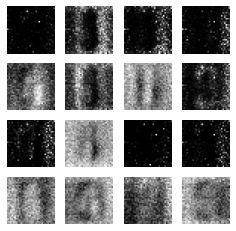

Time for epoch 43 is 1.5155882835388184 sec, generation loss: 0.36480385065078735, discrimination loss: 2.1506733894348145


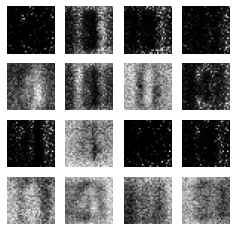

Time for epoch 44 is 1.4171934127807617 sec, generation loss: 0.384521484375, discrimination loss: 2.119460344314575


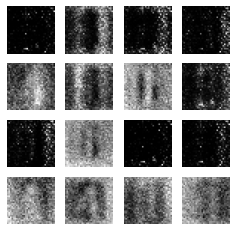

Time for epoch 45 is 1.5225389003753662 sec, generation loss: 0.3415602445602417, discrimination loss: 2.2460029125213623


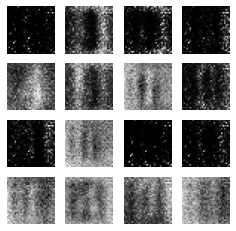

Time for epoch 46 is 1.4388959407806396 sec, generation loss: 0.3527231812477112, discrimination loss: 2.250582456588745


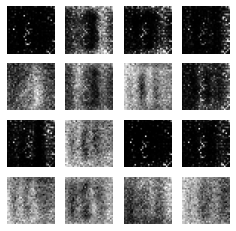

Time for epoch 47 is 1.392742395401001 sec, generation loss: 0.32930734753608704, discrimination loss: 2.3530266284942627


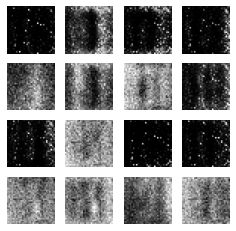

Time for epoch 48 is 1.5953383445739746 sec, generation loss: 0.3158964216709137, discrimination loss: 2.436584949493408


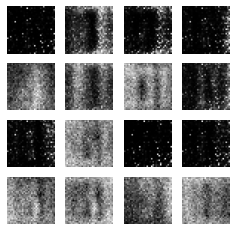

Time for epoch 49 is 1.4648315906524658 sec, generation loss: 0.31713640689849854, discrimination loss: 2.3997607231140137


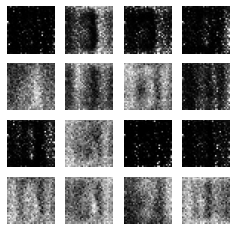

Time for epoch 50 is 1.5390756130218506 sec, generation loss: 0.3223113715648651, discrimination loss: 2.4484548568725586


<Figure size 432x288 with 0 Axes>

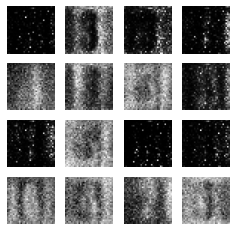

Time for epoch 51 is 1.4510104656219482 sec, generation loss: 0.3037647306919098, discrimination loss: 2.513511896133423


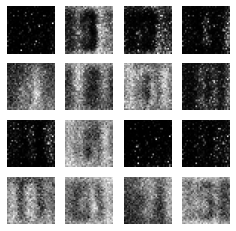

Time for epoch 52 is 1.4548609256744385 sec, generation loss: 0.3141222298145294, discrimination loss: 2.5105512142181396


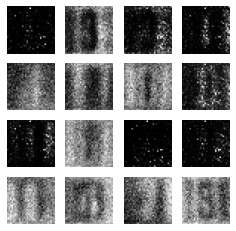

Time for epoch 53 is 1.5358350276947021 sec, generation loss: 0.3171541392803192, discrimination loss: 2.4521048069000244


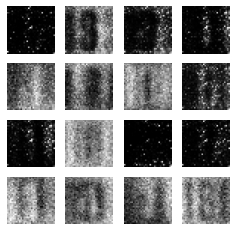

Time for epoch 54 is 1.4390802383422852 sec, generation loss: 0.3202453553676605, discrimination loss: 2.4604110717773438


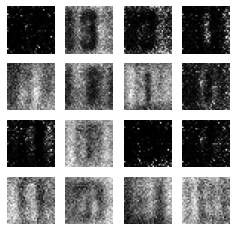

Time for epoch 55 is 1.569371223449707 sec, generation loss: 0.33212241530418396, discrimination loss: 2.470879077911377


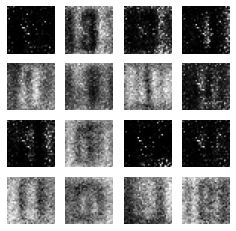

Time for epoch 56 is 1.5065958499908447 sec, generation loss: 0.3100488781929016, discrimination loss: 2.565168857574463


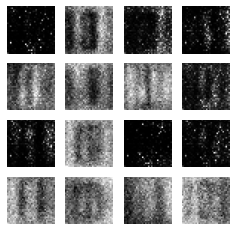

Time for epoch 57 is 1.4324955940246582 sec, generation loss: 0.3383326232433319, discrimination loss: 2.4860973358154297


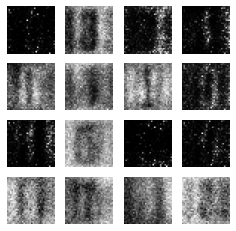

Time for epoch 58 is 1.5503215789794922 sec, generation loss: 0.34868380427360535, discrimination loss: 2.480950117111206


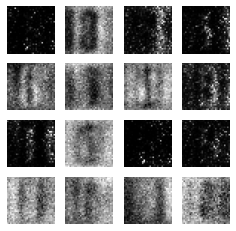

Time for epoch 59 is 1.370436429977417 sec, generation loss: 0.37381577491760254, discrimination loss: 2.4015541076660156


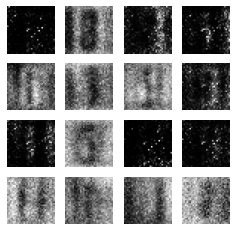

Time for epoch 60 is 1.519197702407837 sec, generation loss: 0.39687737822532654, discrimination loss: 2.3066091537475586


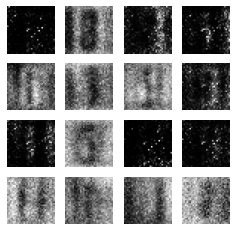

In [33]:
model_='model_0'
train(train_x, 60, generator_0, discriminator_0)

In [34]:

train_loss.to_csv('/content/drive/MyDrive/loss'+model_+'.csv')

In [ ]:
%tensorboard --logdir {gen_log_dir}

In [ ]:
def make_generator_model_1():
  """
  Using CNN to generate images
  Input: random vector, shape = (100,)
  Output: image matrix, shape = (None,32,32,1)
  """
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  return model

In [ ]:
def make_discriminator_model_1():
  """
  Input: image matrix, shape = (32,32,1)
  Output: softmax indicating True/False
  """

  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[32, 32, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  model.add(layers.Activation('sigmoid'))

  return model

In [ ]:
generator_1 = make_generator_model_1()
discriminator_1 = make_discriminator_model_1()

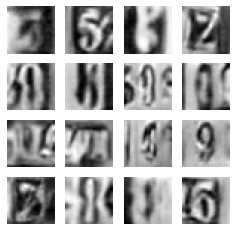

In [ ]:
tf.config.run_functions_eagerly(True)
train(train_x, 500, generator_1, discriminator_1)

In [ ]:
%tensorboard --logdir {gen_log_dir}

In [ ]:
def make_generator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

In [ ]:
def make_discriminator_model_2():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (7, 7), strides=(1, 1), padding='same',input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1))

    return model

In [ ]:
generator_2 = make_generator_model_2()
discriminator_2 = make_discriminator_model_2()

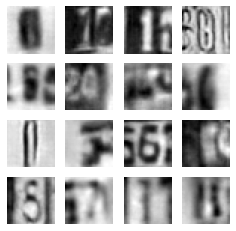

Time for epoch 239 is 37.12943148612976 sec, generation loss: 0.20252874493598938, discrimination loss: 7.1959919929504395


In [ ]:
tf.config.run_functions_eagerly(True)
train(train_x, 500, generator_2, discriminator_2)